## Filter Methods:
    Based on statistical test
    Correlation Coefficient: Measures the linear relationship between two variables.
    Chi-Square Test: Measures the independence between categorical variables.
    Mutual Information: Measures the dependency between variables.
    Variance Threshold: Removes features with low variance.

## Wrapper Methods:

    Forward Selection: Starts with no features, adds one at a time based on model performance.
    Backward Elimination: Starts with all features, removes the least significant feature one at a time.
    Recursive Feature Elimination (RFE): Recursively removes least important features based on model performance.

## Embedded Methods:

    Lasso Regression: Adds a penalty equal to the absolute value of the magnitude of coefficients.
    Ridge Regression: Adds a penalty equal to the square of the magnitude of coefficients.
    Elastic Net: Combines Lasso and Ridge penalties.
    Tree-based Methods: Feature importance based on tree-based models like Random Forests and Gradient Boosting.

In [14]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import VarianceThreshold, mutual_info_classif, chi2, RFE
from sklearn.linear_model import LogisticRegression, Lasso, Ridge, ElasticNet, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.metrics import r2_score
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = "D:/Downloads/archive (22)/loan_data_set.csv"
data = pd.read_csv(file_path)

# Drop 'Loan_ID' and separate features and target variable
X = data.drop(['Loan_ID', 'Loan_Status'], axis=1)
y = data['Loan_Status']

# Encode target variable
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Encode categorical variables
X_encoded = pd.get_dummies(X)

# Handle missing values
imputer = KNNImputer(n_neighbors=3)
X_imputed = imputer.fit_transform(X_encoded)

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)
print(data)

      Loan_ID  Gender Married Dependents     Education Self_Employed  \
0    LP001002    Male      No          0      Graduate            No   
1    LP001003    Male     Yes          1      Graduate            No   
2    LP001005    Male     Yes          0      Graduate           Yes   
3    LP001006    Male     Yes          0  Not Graduate            No   
4    LP001008    Male      No          0      Graduate            No   
..        ...     ...     ...        ...           ...           ...   
609  LP002978  Female      No          0      Graduate            No   
610  LP002979    Male     Yes         3+      Graduate            No   
611  LP002983    Male     Yes          1      Graduate            No   
612  LP002984    Male     Yes          2      Graduate            No   
613  LP002990  Female      No          0      Graduate           Yes   

     ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0               5849                0.0         NaN           

# Filter Methods:

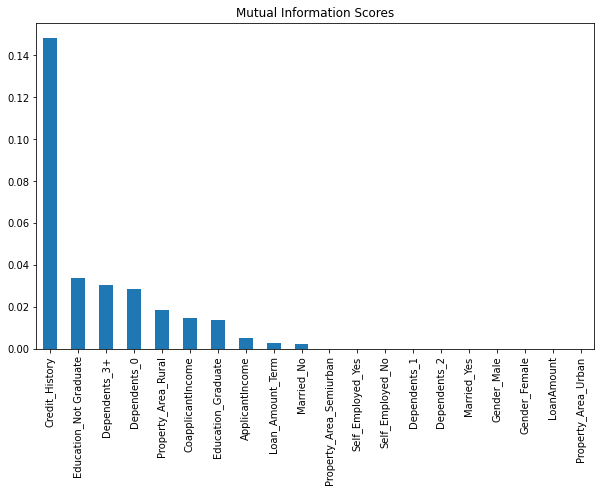

In [2]:
# Mutual Information
mi = mutual_info_classif(X_scaled, y)
mi_series = pd.Series(mi, index=X_encoded.columns)


plt.figure(figsize=(10, 6))
mi_series.sort_values(ascending=False).plot.bar()
plt.title('Mutual Information Scores')
plt.show()

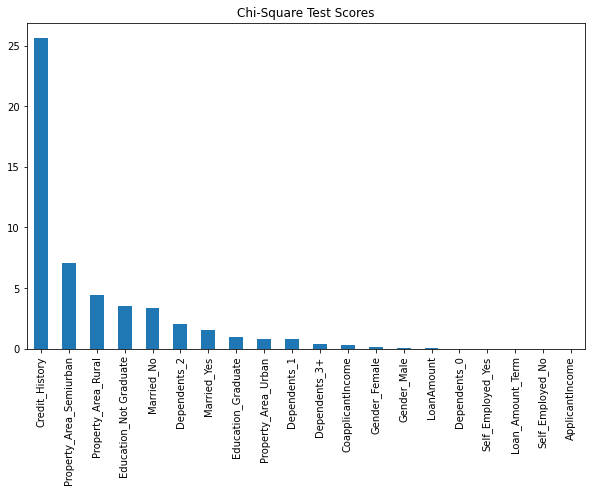

In [12]:
# Chi-Square Test
min_max_scaler = MinMaxScaler()
X_minmax = min_max_scaler.fit_transform(X_imputed)
chi2_scores, p_values = chi2(X_minmax, y)
chi2_series = pd.Series(chi2_scores, index=X_encoded.columns)


plt.figure(figsize=(10, 6))
chi2_series.sort_values(ascending=False).plot.bar()
plt.title('Chi-Square Test Scores')
plt.show()

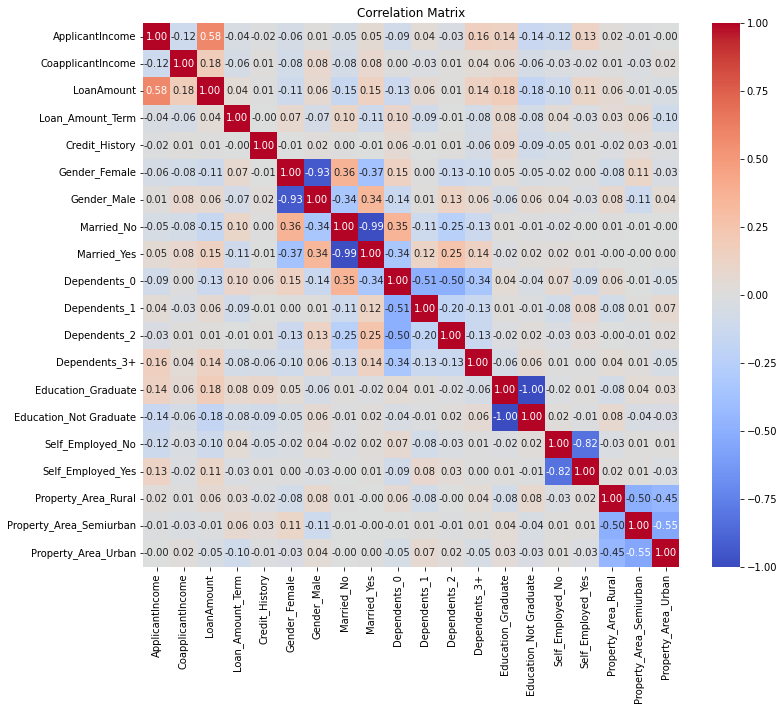

In [15]:
# Correlation Coefficient
correlation_matrix = pd.DataFrame(X_imputed, columns=X_encoded.columns).corr()


plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

# Wrapper Methods:

RFE Selected Features Shape: (614, 5)


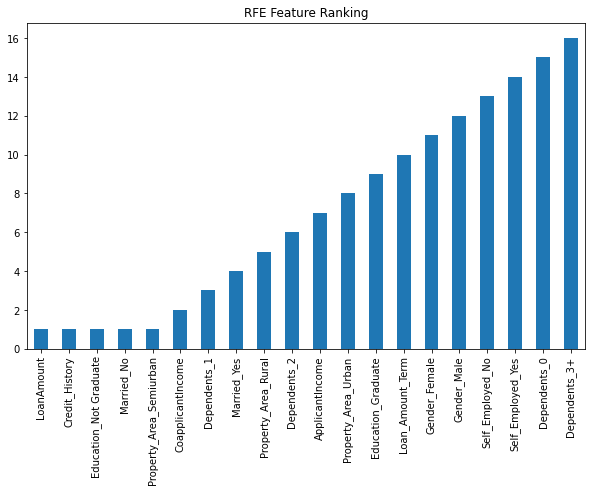

In [5]:
# Recursive Feature Elimination (RFE)
model = LogisticRegression(max_iter=1000)
rfe = RFE(model, n_features_to_select=5)
X_rfe = rfe.fit_transform(X_scaled, y)
print("RFE Selected Features Shape:", X_rfe.shape)


plt.figure(figsize=(10, 6))
rfe_ranking = pd.Series(rfe.ranking_, index=X_encoded.columns)
rfe_ranking.sort_values().plot.bar()
plt.title('RFE Feature Ranking')
plt.show()

Initial Model Summary:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.319
Model:                            OLS   Adj. R-squared:                  0.299
Method:                 Least Squares   F-statistic:                     15.51
Date:                Wed, 05 Jun 2024   Prob (F-statistic):           3.89e-39
Time:                        10:02:32   Log-Likelihood:                -281.12
No. Observations:                 614   AIC:                             600.2
Df Residuals:                     595   BIC:                             684.2
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
con

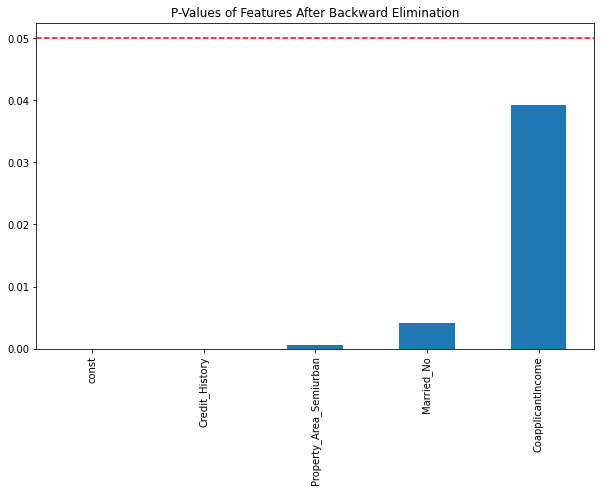

In [6]:
# Backward Elimination
X_with_const = sm.add_constant(pd.DataFrame(X_scaled, columns=X_encoded.columns))
model = sm.OLS(y, X_with_const).fit()
print("Initial Model Summary:")
print(model.summary())

while True:
    p_values = pd.Series(model.pvalues, index=X_with_const.columns)
    max_p_value = p_values.max()
    if max_p_value > 0.05:
        excluded_feature = p_values.idxmax()
        print(f"Dropping {excluded_feature}")
        X_with_const = X_with_const.drop(columns=[excluded_feature])
        model = sm.OLS(y, X_with_const).fit()
    else:
        break

print("Final Model Summary:")
print(model.summary())

# Visualization of Backward Elimination
plt.figure(figsize=(10, 6))
p_values.sort_values().plot.bar()
plt.axhline(y=0.05, color='r', linestyle='--')
plt.title('P-Values of Features After Backward Elimination')
plt.show()

Selected features (indices): [4, 18, 7, 1, 10, 2, 14, 19, 11, 3, 0, 8, 15, 16, 6, 5, 9, 12, 13]


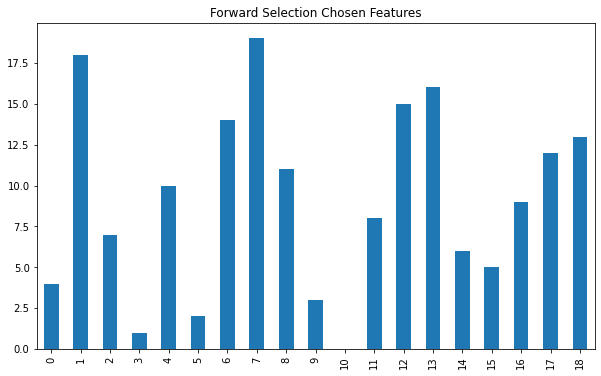

In [7]:
# Forward Selection
remaining_features = list(range(X_scaled.shape[1]))
selected_features = []
current_score, best_new_score = 0.0, 0.0

while remaining_features and current_score == best_new_score:
    scores_with_candidates = []
    for candidate in remaining_features:
        features_to_try = selected_features + [candidate]
        model = LinearRegression()
        model.fit(X_scaled[:, features_to_try], y)
        score = r2_score(y, model.predict(X_scaled[:, features_to_try]))
        scores_with_candidates.append((score, candidate))
    
    scores_with_candidates.sort(reverse=True)
    best_new_score, best_candidate = scores_with_candidates[0]
    if current_score < best_new_score:
        remaining_features.remove(best_candidate)
        selected_features.append(best_candidate)
        current_score = best_new_score

print("Selected features (indices):", selected_features)

# Visualization of Forward Selection
plt.figure(figsize=(10, 6))
forward_selected_features = pd.Series(selected_features)
forward_selected_features.plot(kind='bar')
plt.title('Forward Selection Chosen Features')
plt.show()

# Embedded Methods:

Lasso Coefficients:
[ 0.         -0.         -0.         -0.          0.14605572 -0.
  0.         -0.          0.         -0.         -0.          0.
 -0.          0.         -0.          0.         -0.         -0.
  0.         -0.        ]


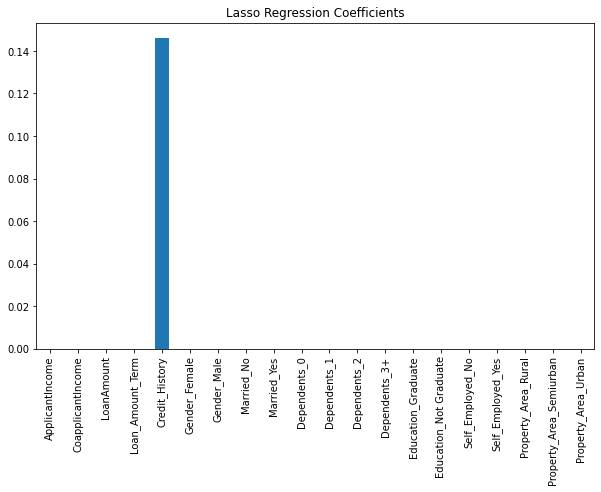

In [8]:
# Lasso Regression
lasso = Lasso(alpha=0.1)
lasso.fit(X_scaled, y)
print("Lasso Coefficients:")
print(lasso.coef_)

# Visualization of Lasso Coefficients
plt.figure(figsize=(10, 6))
lasso_coefficients = pd.Series(lasso.coef_, index=X_encoded.columns)
lasso_coefficients.plot(kind='bar')
plt.title('Lasso Regression Coefficients')
plt.show()

Ridge Coefficients:
[ 0.01198102 -0.02818727 -0.02921305 -0.01001761  0.24270978  0.00996648
  0.00999456 -0.10355527 -0.05721514  0.00577958 -0.01763945  0.01724876
  0.00324774  0.01135585 -0.01135585  0.00914944  0.00659059 -0.0267295
  0.03514268 -0.01044077]


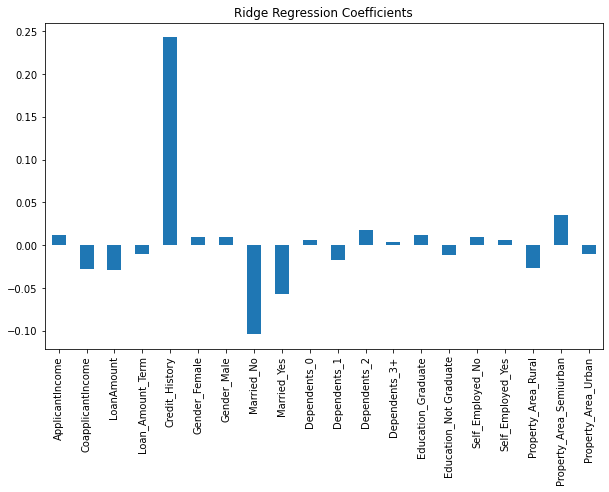

In [9]:
# Ridge Regression
ridge = Ridge(alpha=0.1)
ridge.fit(X_scaled, y)

# Visualization of Ridge Coefficients
plt.figure(figsize=(10, 6))
ridge_coefficients = pd.Series(ridge.coef_, index=X_encoded.columns)
ridge_coefficients.plot(kind='bar')
plt.title('Ridge Regression Coefficients')
plt.show()

Elastic Net Coefficients:
[ 0.         -0.         -0.         -0.          0.18650781 -0.
  0.         -0.          0.         -0.         -0.          0.
 -0.          0.         -0.          0.         -0.         -0.
  0.00709615 -0.        ]


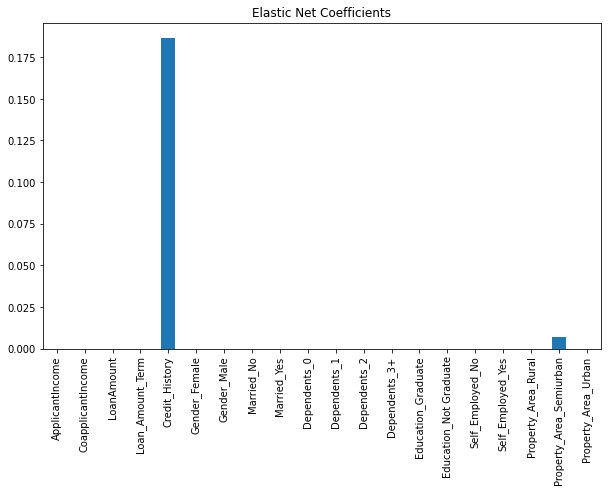

In [10]:
# Elastic Net
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X_scaled, y)

# Visualization of Elastic Net Coefficients
plt.figure(figsize=(10, 6))
elastic_net_coefficients = pd.Series(elastic_net.coef_, index=X_encoded.columns)
elastic_net_coefficients.plot(kind='bar')
plt.title('Elastic Net Coefficients')
plt.show()

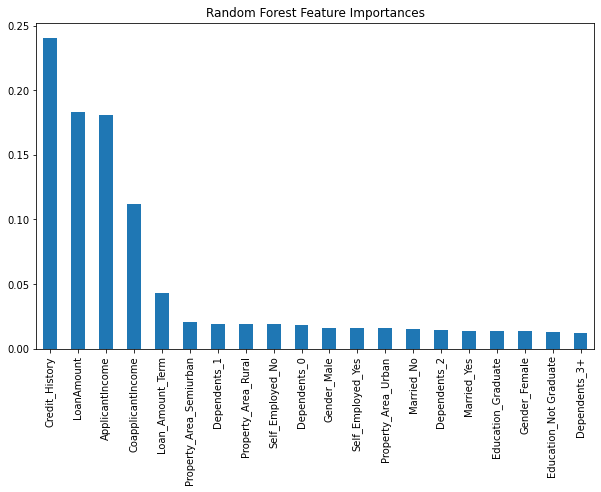

In [16]:
# Tree-based Methods
model = RandomForestClassifier()
model.fit(X_scaled, y)
importances = model.feature_importances_
importances_series = pd.Series(importances, index=X_encoded.columns)

# Visualization of Random Forest Feature Importances
plt.figure(figsize=(10, 6))
importances_series.sort_values(ascending=False).plot.bar()
plt.title('Random Forest Feature Importances')
plt.show()